In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

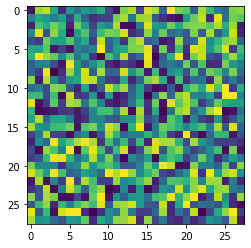

In [3]:
plt.imshow(x[0,0])

In [4]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
  """
  input_data : (N, C, H, W)
  filter_h : int
  filter_w : int
  strid : int
  pad : int
  """
  N, C, H, W = input_data.shape
  output_h = (H + 2 * pad - filter_h) // stride + 1
  output_w = (W + 2 * pad - filter_w) // stride + 1
  img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
  col = np.zeros((N, C, filter_h, filter_w, output_h ,output_w))

  for y in range(filter_h):
    y_max = y + stride * output_h
    for x in range(filter_w):
      x_max = x + stride * output_w
      col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
  col = col.transpose(0,4,5,1,2,3).reshape(N*output_h*output_w, -1)
  return col

In [5]:
# BEST im2col function (This is better than upper code.)
def im2col(input_img, FH, FW, stride=1, pad=0):
  N, C, H, W = input_img.shape
  out_h = 1 + int((H + 2 * pad - FH) / stride)
  out_w = 1 + int((W + 2 * pad - FW) / stride)
  img = np.pad(input_img, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant') # img.shape : N, C, out_h, out_w
  out_img = np.zeros((N, C, FH, FW, out_h, out_w))
  for y in range(out_h):
    y_left=y*stride
    for x in range(out_w):
      x_left=x*stride
      out_img[:, :, :, :, y, x] = img[:, :, y_left:y_left+FH,x_left:x_left+FW]
  out_img = np.transpose(out_img, (0, 4, 5, 1, 2, 3)) # out_img.shape: N, out_h, out_w, C, FH, FW
  out_img = out_img.reshape(N * out_h * out_w, -1)
  return out_img

In [6]:
def col2im(col, input_shape, FH, FW, stride=1, pad=0):
  N, C, H, W = input_shape
  out_h = 1 + int((H + 2 * pad - FH) / stride)
  out_w = 1 + int((W + 2 * pad - FW) / stride)
  col = col.reshape(N, out_h, out_w, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
  img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
  for y in range(out_h):
    y_left = y*stride
    for x in range(out_w):
      x_left=x*stride
      img[:, :, y_left:y_left+FH, x_left:x_left+FW] = col[:, :, :, :, y, x]
  return img[:, :, pad:H + pad, pad:W + pad]

In [7]:
class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    self.W = W  # W.shape : FN, C, filter_h, filter_w
    self.b = b  # b.shape : FN
    self.stride = stride
    self.pad = pad

  def forward(self, x): # x.shape : N, C, H, W
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
    out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
    col = im2col(x, FH, FW, self.stride, self.pad)      # col.shape : N x out_h x out_w, C x filter_h x filter_w
    col_W = self.W.reshape(FN, -1).T                    # col_W.shape : C x filter_h x filter_w, FN
    out = np.dot(col, col_W) + self.b                   # out.shape : N x out_h x out_w, FN

    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)  # out.shape : N, FN, out_h, out_w

    self.x = x
    self.col = col
    self.col_W = col_W
    return out

  def backward(self, dout): # dout.shape : N, FN, out_h, out_w
    FN, C, FH, FW = self.W.shape
    N, C, H, W = self.x.shape
    dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN) # dout.shape : N x out_h x out_w, FN

    self.db = np.sum(dout, axis=0)                    # db.shape : FN
    d_col_W = np.dot(self.col.T, dout)
    self.dW = d_col_W.transpose(1, 0).reshape(FN, C, FH, FW)
    d_col = np.dot(dout, self.col_W.T)
    self.dx = col2im(d_col, self.x.shape, FH, FW, self.stride, self.pad)

    return self.dx 

In [8]:
class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, padding=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.padding = padding
  
  def forward(self, x):
    N, C, H, W = x.shape
    output_h = 1 + (H - self.pool_h) // self.stride
    output_w = 1 + (W - self.pool_w) // self.stride
    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.padding)
    col = col.reshape(-1, self.pool_h * self.pool_w)

    arg_max = np.argmax(col, axis=1)
    out = np.max(col, axis=1)
    out = out.reshape(N, output_h, output_w, C).transpose(0, 3, 1, 2)

    self.x = x
    self.arg_max = arg_max

    return out
  
  def backward(self, dout):
    dout = dout.transpose(0,2,3,1)

    pool_size = self.pool_h * self.pool_w
    dmax = np.zeros((dout.size, pool_size))
    dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
    dmax = dmax.reshape(dout.shape + (pool_size,))
    dcol = dmax.reshape(dmax.shape[0]*dmax.shape[1]*dmax.shape[2], -1)
    dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

    return dx

In [9]:
class Relu:
  def __init__(self):
    pass
  
class Affine:
  def __init__(self):
    pass
  
class SoftmaxWithLoss:
  def __init__(self):
    pass

In [10]:
from collections import OrderedDict

class SimpleConvNet:
  def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}, \
    hidden_size=100, output_size=10, weight_init_std=0.01):
    
    filter_num = conv_param['filter_num']
    filter_size = conv_param['filter_size']
    filter_pad = conv_param['pad']
    filter_stride = conv_param['stride']
    input_size = input_dim[1]

    conv_output_size = (input_size - filter_size + 2 * filter_pad) // filter_stride + 1
    pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

    #
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)

    self.layers = OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
    self.layers['Relu1'] = Relu()
    self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
    self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
    self.last_layer = SoftmaxWithLoss()
  
  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    return x
  
  def loss(self, x, t):
    y = self.predict(x)
    return self.last_layer.forward(y, t)

  def gradient(self, x, t):
    self.loss(x ,t)

    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)
    
    grads = {}
    grads['W1'] = self.layers['Conv1'].dW
    grads['b1'] = self.layers['Conv1'].db
    grads['W2'] = self.layers['Affine1'].dW
    grads['b2'] = self.layers['Affine1'].db
    grads['W3'] = self.layers['Affine2'].dW
    grads['b3'] = self.layers['Affine2'].db

    return grads